In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from skimage import color
from skimage.filters import gabor
from tqdm import tqdm

from utils.load_data import load_split
from utils.ml_training import plot_classification_metrics, plot_model_sizes, plot_training_times, run_ml_experiments
from utils.types import FeatureVector_float32, RGBImage_uint8


In [2]:
train_images, train_labels = load_split("data/train/", library="pil")
len(train_images), train_images[0].shape, train_labels.shape


Loading REAL images: 100%|██████████| 50000/50000 [00:06<00:00, 7385.21it/s]

Loading FAKE images: 100%|██████████| 50000/50000 [00:09<00:00, 5292.01it/s]


(100000, (32, 32, 3), (100000,))

In [3]:
test_images, test_labels = load_split("data/test/", library="pil")
len(test_images), test_images[0].shape, test_labels.shape


Loading REAL images:   0%|          | 0/10000 [00:00<?, ?it/s]

Loading FAKE images: 100%|██████████| 10000/10000 [00:01<00:00, 6932.76it/s]


(20000, (32, 32, 3), (20000,))

In [4]:
# Matches the Gabor configuration tested in test.ipynb
GABOR_FREQUENCIES = [0.2, 0.4]
GABOR_THETAS = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]


In [5]:
def extract_gabor_feature(img: RGBImage_uint8) -> FeatureVector_float32:
    """Return stacked mean/std magnitudes of the configured Gabor responses."""
    gray = color.rgb2gray(img).astype(np.float32)
    feats: list[float] = []
    for freq in GABOR_FREQUENCIES:
        for theta in GABOR_THETAS:
            real, imag = gabor(gray, frequency=freq, theta=theta)
            magnitude = np.sqrt(real**2 + imag**2)
            feats.append(float(magnitude.mean()))
            feats.append(float(magnitude.std()))
    return np.array(feats, dtype=np.float32)


In [6]:
extract_gabor_feature(train_images[0]).shape


(16,)

In [7]:
gabor_features_list_train: list[FeatureVector_float32] = [
    extract_gabor_feature(img) for img in tqdm(train_images, desc="Extracting Gabor features from train images")
]
gabor_features_list_test: list[FeatureVector_float32] = [
    extract_gabor_feature(img) for img in tqdm(test_images, desc="Extracting Gabor features from test images")
]


Extracting Gabor features from test images: 100%|██████████| 20000/20000 [02:02<00:00, 163.24it/s]


In [8]:
real_gabor_feat: FeatureVector_float32 = np.array(gabor_features_list_train)[:50000].mean(axis=0)
fake_gabor_feat: FeatureVector_float32 = np.array(gabor_features_list_train)[50000:].mean(axis=0)


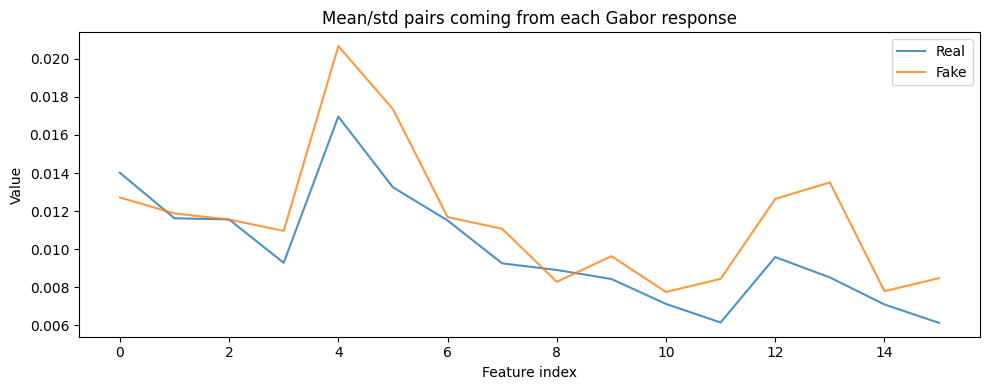

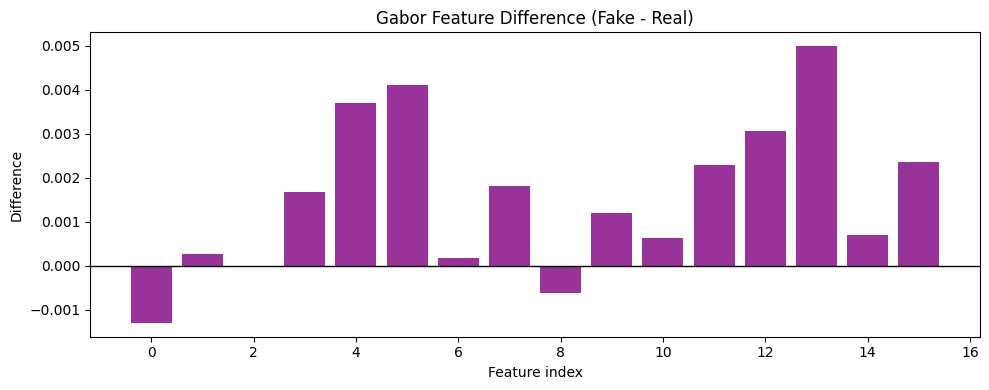

In [9]:
def plot_gabor_feature_trends(real_feat: FeatureVector_float32, fake_feat: FeatureVector_float32) -> None:
    x = np.arange(len(real_feat))
    plt.figure(figsize=(10, 4))
    plt.plot(x, real_feat, label="Real", alpha=0.8)
    plt.plot(x, fake_feat, label="Fake", alpha=0.8)
    plt.title("Mean/std pairs coming from each Gabor response")
    plt.xlabel("Feature index")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_gabor_feature_diffs(real_feat: FeatureVector_float32, fake_feat: FeatureVector_float32) -> None:
    diff = fake_feat - real_feat
    x = np.arange(len(real_feat))
    plt.figure(figsize=(10, 4))
    plt.bar(x, diff, color="purple", alpha=0.8)
    plt.axhline(0, color="black", linewidth=1)
    plt.title("Gabor Feature Difference (Fake - Real)")
    plt.xlabel("Feature index")
    plt.ylabel("Difference")
    plt.tight_layout()
    plt.show()


plot_gabor_feature_trends(real_gabor_feat, fake_gabor_feat)
plot_gabor_feature_diffs(real_gabor_feat, fake_gabor_feat)


In [10]:
X_train = np.array(gabor_features_list_train)
y_train = train_labels
X_test = np.array(gabor_features_list_test)
y_test = test_labels


In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((100000, 16), (20000, 16), (100000,), (20000,))

In [12]:
X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype


(dtype('float32'), dtype('float32'), dtype('uint8'), dtype('uint8'))

In [13]:
rng = np.random.RandomState(42)
shuffle_indices = rng.permutation(len(X_train))
X_train = X_train[shuffle_indices]
y_train = y_train[shuffle_indices]


In [14]:
path_output = Path("outputs/gabor_classification_results.json")
results = run_ml_experiments(X_train, y_train, X_test, y_test, path_output)



GaussianNB:
Training time (sec): 0.02
              precision    recall  f1-score   support

        Real     0.6685    0.8013    0.7289     10000
        Fake     0.7520    0.6026    0.6691     10000

    accuracy                         0.7019     20000
   macro avg     0.7103    0.7020    0.6990     20000
weighted avg     0.7103    0.7019    0.6990     20000

Model size (joblib): 0.001 MB

KNN:
Training time (sec): 0.00
              precision    recall  f1-score   support

        Real     0.8308    0.8282    0.8295     10000
        Fake     0.8287    0.8313    0.8300     10000

    accuracy                         0.8297     20000
   macro avg     0.8298    0.8297    0.8297     20000
weighted avg     0.8298    0.8297    0.8297     20000

Model size (joblib): 5.280 MB

KNN:
Training time (sec): 0.00
              precision    recall  f1-score   support

        Real     0.8308    0.8282    0.8295     10000
        Fake     0.8287    0.8313    0.8300     10000

    accuracy       

d:\AT82.08-AI-Generated-Image-Classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


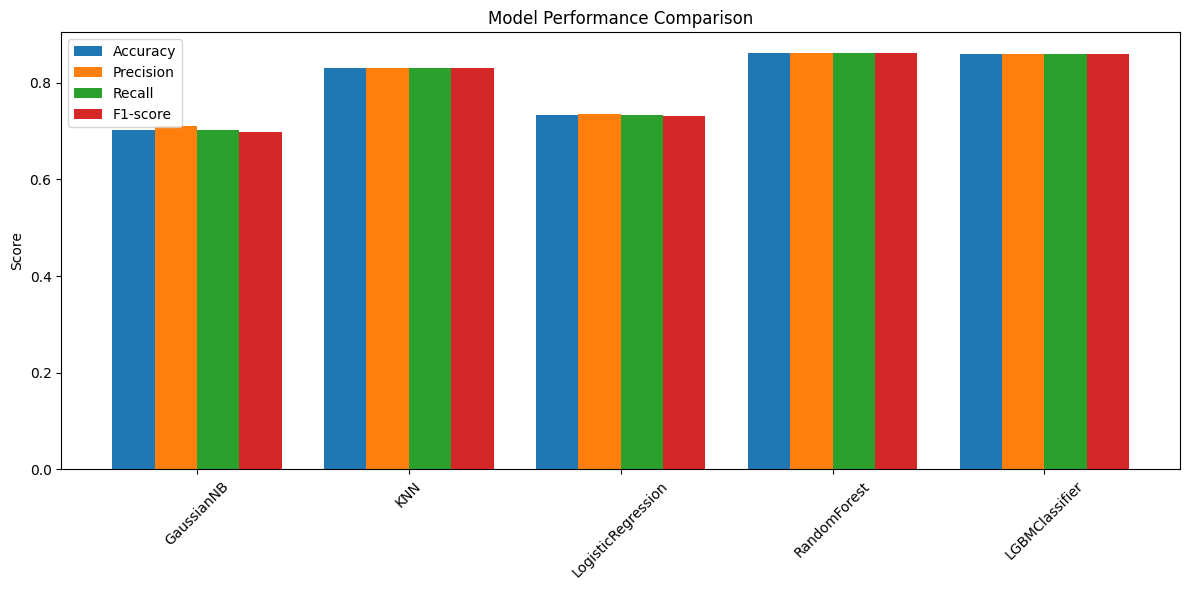

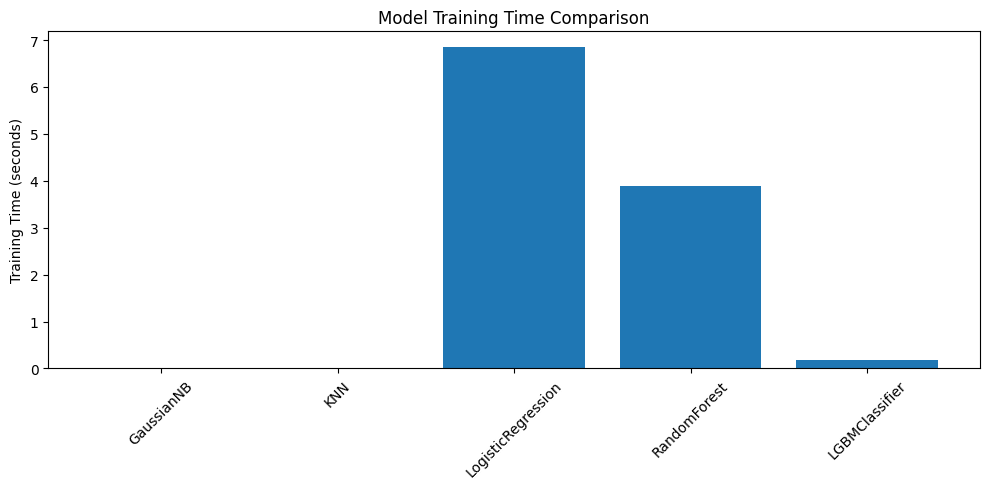

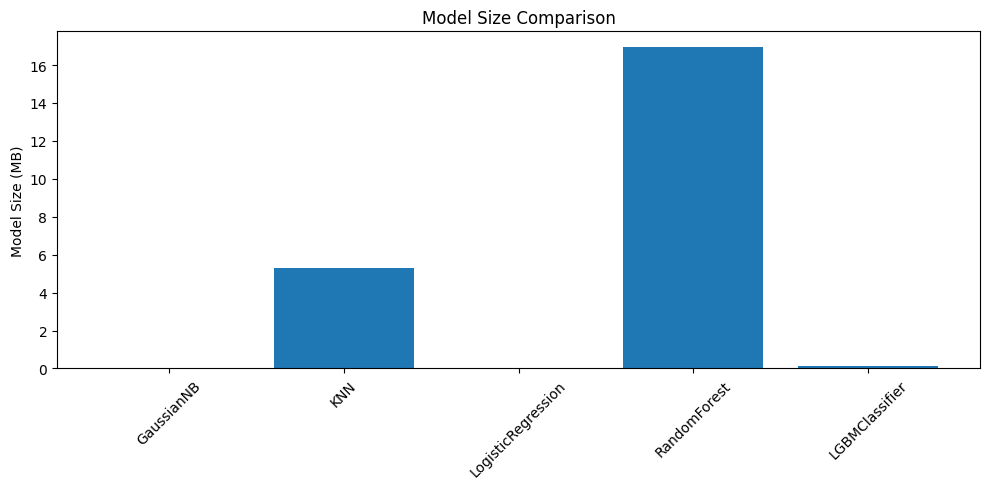

In [15]:
plot_classification_metrics(results)
plot_training_times(results)
plot_model_sizes(results)
